In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import Any, Callable, Dict, List, Optional, Sequence
from functools import partial
from torch.nn import init
from torch import nn, Tensor
from torch.optim.lr_scheduler import StepLR
from collections import OrderedDict

from torchinfo import summary
import matplotlib.pyplot as plt
import seaborn as sns


from torch.hub import load_state_dict_from_url
from torchvision.ops.misc import Conv2dNormActivation
from torchvision.models.mobilenetv2 import _make_divisible

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("using", device, "device")

using cuda device


In [3]:
# Data directory
data_dir_train = "rundataset/train_set"
data_dir_test = "rundataset/test_set"

In [4]:
train_set = datasets.ImageFolder(root = data_dir_train)

test_set = datasets.ImageFolder(root = data_dir_test)

In [5]:
# Jumlah total gambar di dataset
total_images = len(train_set)
print(f"The dataset have {total_images} images")

# Jumlah gambar tiap kelas
class_counts = Counter(train_set.targets)
print("Images distribution on each class")
for class_name, count in zip(train_set.classes, class_counts.values()):
    print(f"{class_name:<17} : {count:>5} images")

The dataset have 31991 images
Images distribution on each class
Alternaria leaf spot :  3998 images
Brown spot        :  3996 images
Frog eye leaf spot :  4000 images
Gray spot         :  3999 images
Healthy           :  3998 images
Powdery mildew    :  4000 images
Rust              :  4000 images
Scab              :  4000 images


In [6]:
# Normalization and Resizing image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize(           
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]   
    )
])

train_set = datasets.ImageFolder(root=data_dir_train, transform=transform)

test_set = datasets.ImageFolder(root=data_dir_test, transform=transform)

In [7]:
# Bagi dataset menjadi train, val, dan test set
train_size = int(0.9 * len(train_set))  # 90% untuk training
val_size = len(train_set) - train_size  # Sisanya untuk validation

train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

# DataLoader untuk train, val, dan test set
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [8]:
# Function to count class distribution on each dataset
def get_class_distribution(dataset):
    if isinstance(dataset, torch.utils.data.Subset):
        return Counter(dataset.dataset.targets[i] for i in dataset.indices)
    else:
        return Counter(dataset.targets)  # Untuk dataset asli seperti ImageFolder

# Distribusi kelas di setiap subset
train_class_distribution = get_class_distribution(train_dataset)
val_class_distribution = get_class_distribution(val_dataset)
test_class_distribution = get_class_distribution(test_set)

def print_class_distribution(title, class_distribution):
    print(title)
    for class_id, count in sorted(class_distribution.items(), key=lambda x: train_set.classes[x[0]]):
        print(f"{train_set.classes[class_id]:<18}: {count:>4} images")
    print()

print_class_distribution("Training set have:", train_class_distribution)
print_class_distribution("Validation set have:", val_class_distribution)
print_class_distribution("Training set have:", test_class_distribution)

Training set have:
Alternaria leaf spot: 3594 images
Brown spot        : 3609 images
Frog eye leaf spot: 3594 images
Gray spot         : 3569 images
Healthy           : 3612 images
Powdery mildew    : 3612 images
Rust              : 3591 images
Scab              : 3610 images

Validation set have:
Alternaria leaf spot:  404 images
Brown spot        :  387 images
Frog eye leaf spot:  406 images
Gray spot         :  430 images
Healthy           :  386 images
Powdery mildew    :  388 images
Rust              :  409 images
Scab              :  390 images

Training set have:
Alternaria leaf spot:  101 images
Brown spot        :  101 images
Frog eye leaf spot:  100 images
Gray spot         :  100 images
Healthy           :  100 images
Powdery mildew    :  100 images
Rust              :  100 images
Scab              :  100 images



In [ ]:
'''MobileNetV3 in PyTorch with CoordAtt replacing SqueezeExcitation.

See the paper "Inverted Residuals and Linear Bottlenecks:
Mobile Networks for Classification, Detection and Segmentation" for more details.
'''

class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)
    
class Concurrent(nn.Sequential):
    """
    A container for concatenation of modules on the base of the sequential container.

    Parameters:
    ----------
    axis : int, default 1
        The axis on which to concatenate the outputs.
    stack : bool, default False
        Whether to concatenate tensors along a new dimension.
    """
    def __init__(self,
                 axis=1,
                 stack=False):
        super(Concurrent, self).__init__()
        self.axis = axis
        self.stack = stack

    def forward(self, x):
        out = []
        for module in self._modules.values():
            out.append(module(x))
        if self.stack:
            out = torch.stack(tuple(out), dim=self.axis)
        else:
            out = torch.cat(tuple(out), dim=self.axis)
        return out

class SKConvBlock(nn.Module):
    """
    SKNet specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    groups : int, default 32
        Number of groups in branches.
    num_branches : int, default 2
        Number of branches (`M` parameter in the paper).
    reduction : int, default 16
        Reduction value for intermediate channels (`r` parameter in the paper).
    min_channels : int, default 32
        Minimal number of intermediate channels (`L` parameter in the paper).
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 stride=1,
                 groups=8,
                 num_branches=2,
                 reduction=16,
                 min_channels=32):
        super(SKConvBlock, self).__init__()
        self.num_branches = num_branches
        self.out_channels = out_channels
        mid_channels = max(in_channels // reduction, min_channels)

        self.branches = Concurrent(stack=True)
        for i in range(num_branches):
            dilation = 1 + i
            self.branches.add_module("branch{}".format(i + 2), nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=stride,
                padding=dilation,
                dilation=dilation,
                groups=groups))
        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc1 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=mid_channels,
            kernel_size=1)
        self.fc2 = nn.Conv2d(
            in_channels=mid_channels,
            out_channels=(out_channels * num_branches),
            kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        y = self.branches(x)

        u = y.sum(dim=1)
        s = self.pool(u)
        z = self.fc1(s)
        w = self.fc2(z)

        batch = w.size(0)
        w = w.view(batch, self.num_branches, self.out_channels)
        w = self.softmax(w)
        w = w.unsqueeze(-1).unsqueeze(-1)

        y = y * w
        y = y.sum(dim=1)
        return y
    
class CoordAtt(nn.Module):
    def __init__(self, inp, oup, reduction=32):
        super(CoordAtt, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))

        mip = max(8, inp // reduction)

        self.conv1 = nn.Conv2d(inp, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mip)
        self.act = h_swish()
        
        self.conv_h = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        self.conv_w = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        

    def forward(self, x):
        identity = x
        
        n,c,h,w = x.size()
        x_h = self.pool_h(x)
        x_w = self.pool_w(x).permute(0, 1, 3, 2)

        y = torch.cat([x_h, x_w], dim=2)
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.act(y) 
        
        x_h, x_w = torch.split(y, [h, w], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)

        a_h = self.conv_h(x_h).sigmoid()
        a_w = self.conv_w(x_w).sigmoid()

        out = identity * a_w * a_h

        return out

class MultiScaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MultiScaleFeatureExtractor, self).__init__()
        
        # Define the intermediate channel size for each branch
        mid_channels = out_channels // 4
        
        # Branch 1: 1x1 convolution path
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(mid_channels)
        )
        
        # Branch 2: 3x3 convolution path
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(mid_channels)
        )
        
        # Branch 3: 5x5 convolution path
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(mid_channels)
        )
        
        # Branch 4: 7x7 convolution path
        self.branch4 = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(mid_channels)
        )
        
        # Final 1x1 convolution after concatenation
        self.final_conv = nn.Sequential(
            nn.Conv2d(mid_channels * 4, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        # Process input through each branch
        branch1_output = self.branch1(x)
        branch2_output = self.branch2(x)
        branch3_output = self.branch3(x)
        branch4_output = self.branch4(x)
        
        # Concatenate outputs from all branches along channel dimension
        concat_output = torch.cat([branch1_output, branch2_output, branch3_output, branch4_output], dim=1)
        
        # Apply final 1x1 convolution
        output = self.final_conv(concat_output)
        
        return output


class InvertedResidualConfig:
    def __init__(self, input_channels: int, kernel: int, expanded_channels: int, out_channels: int, use_se: bool,
                 activation: str, stride: int, dilation: int, width_mult: float, stage: int):
        self.input_channels = self.adjust_channels(input_channels, width_mult)
        self.kernel = kernel
        self.expanded_channels = self.adjust_channels(expanded_channels, width_mult)
        self.out_channels = self.adjust_channels(out_channels, width_mult)
        self.use_se = use_se  # We'll still use this flag but apply it with the appropriate attention mechanism
        self.use_hs = activation == "HS"
        self.stride = stride
        self.dilation = dilation
        self.stage = stage  # Added stage parameter to determine attention type

    @staticmethod
    def adjust_channels(channels: int, width_mult: float):
        return _make_divisible(channels * width_mult, 8)


class InvertedResidual(nn.Module):
    def __init__(self, cnf: InvertedResidualConfig, norm_layer: Callable[..., nn.Module]):
        super().__init__()
        if not (1 <= cnf.stride <= 2):
            raise ValueError('illegal stride value')

        self.use_res_connect = cnf.stride == 1 and cnf.input_channels == cnf.out_channels

        layers: List[nn.Module] = []
        activation_layer = nn.Hardswish if cnf.use_hs else nn.ReLU

        # expand
        if cnf.expanded_channels != cnf.input_channels:
            layers.append(Conv2dNormActivation(cnf.input_channels, cnf.expanded_channels, kernel_size=1,
                                           norm_layer=norm_layer, activation_layer=activation_layer))

        # depthwise
        stride = 1 if cnf.dilation > 1 else cnf.stride
        layers.append(Conv2dNormActivation(cnf.expanded_channels, cnf.expanded_channels, kernel_size=cnf.kernel,
                                       stride=stride, dilation=cnf.dilation, groups=cnf.expanded_channels,
                                       norm_layer=norm_layer, activation_layer=activation_layer))
        
        # Add attention module based on stage
        if cnf.use_se:
            # Use SKAttention for stages 1 and 2, CoordAtt for stages 3 and 4
            if cnf.stage <= 2:
                layers.append(SKConvBlock(cnf.expanded_channels, cnf.expanded_channels))
            else:
                layers.append(CoordAtt(cnf.expanded_channels, cnf.expanded_channels))

        # project
        layers.append(Conv2dNormActivation(cnf.expanded_channels, cnf.out_channels, kernel_size=1, norm_layer=norm_layer,
                                       activation_layer=nn.Identity))

        self.block = nn.Sequential(*layers)
        self.out_channels = cnf.out_channels
        self._is_cn = cnf.stride > 1

    def forward(self, input: Tensor) -> Tensor:
        result = self.block(input)
        if self.use_res_connect:
            result += input
        return result


class MobileNetV3(nn.Module):
    def __init__(
            self,
            inverted_residual_setting: List[InvertedResidualConfig],
            last_channel: int,
            num_classes: int = 1000,
            block: Optional[Callable[..., nn.Module]] = None,
            norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        """
        MobileNet V3 main class

        Args:
            inverted_residual_setting (List[InvertedResidualConfig]): Network structure
            last_channel (int): The number of channels on the penultimate layer
            num_classes (int): Number of classes
            block (Optional[Callable[..., nn.Module]]): Module specifying inverted residual building block for mobilenet
            norm_layer (Optional[Callable[..., nn.Module]]): Module specifying the normalization layer to use
        """
        super().__init__()

        if not inverted_residual_setting:
            raise ValueError("The inverted_residual_setting should not be empty")
        elif not (isinstance(inverted_residual_setting, Sequence) and
                  all([isinstance(s, InvertedResidualConfig) for s in inverted_residual_setting])):
            raise TypeError("The inverted_residual_setting should be List[InvertedResidualConfig]")

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = partial(nn.BatchNorm2d, eps=0.001, momentum=0.01)

        layers: List[nn.Module] = []

        # building first layer
        firstconv_output_channels = inverted_residual_setting[0].input_channels
        layers.append(MultiScaleFeatureExtractor(3, firstconv_output_channels))
        
        # Add activation after MSFE
        layers.append(nn.Hardswish())
        
        # building inverted residual blocks
        for cnf in inverted_residual_setting:
            layers.append(block(cnf, norm_layer))

        # building last several layers
        lastconv_input_channels = inverted_residual_setting[-1].out_channels
        lastconv_output_channels = 6 * lastconv_input_channels
        layers.append(Conv2dNormActivation(lastconv_input_channels, lastconv_output_channels, kernel_size=1,
                                       norm_layer=norm_layer, activation_layer=nn.Hardswish))

        self.features = nn.Sequential(*layers)  
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(lastconv_output_channels, last_channel),
            nn.Hardswish(inplace=True),
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(last_channel, num_classes),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.features(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.classifier(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _mobilenet_v3_conf(arch: str, params: Dict[str, Any]):
    # non-public config parameters
    reduce_divider = 2 if params.pop('_reduced_tail', False) else 1
    dilation = 2 if params.pop('_dilated', False) else 1
    width_mult = params.pop('_width_mult', 1.0)

    # Create partial function with additional stage parameter
    bneck_conf = lambda input_channels, kernel, expanded_channels, out_channels, use_se, activation, stride, stage: \
        InvertedResidualConfig(input_channels, kernel, expanded_channels, out_channels, use_se, activation, stride, 
                              dilation if stage > 3 else 1, width_mult, stage)

    adjust_channels = partial(InvertedResidualConfig.adjust_channels, width_mult=width_mult)

    if arch == "mobilenet_v3_large":
        inverted_residual_setting = [
            bneck_conf(16, 3, 16, 16, False, "RE", 1, 1),
            bneck_conf(16, 3, 64, 24, False, "RE", 2, 1),  # C1
            bneck_conf(24, 3, 72, 24, False, "RE", 1, 1),
            bneck_conf(24, 5, 72, 40, True, "RE", 2, 2),  # C2
            bneck_conf(40, 5, 120, 40, True, "RE", 1, 2),
            bneck_conf(40, 5, 120, 40, True, "RE", 1, 2),
            bneck_conf(40, 3, 240, 80, False, "HS", 2, 3),  # C3
            bneck_conf(80, 3, 200, 80, False, "HS", 1, 3),
            bneck_conf(80, 3, 184, 80, False, "HS", 1, 3),
            bneck_conf(80, 3, 184, 80, False, "HS", 1, 3),
            bneck_conf(80, 3, 480, 112, True, "HS", 1, 3),
            bneck_conf(112, 3, 672, 112, True, "HS", 1, 3),
            bneck_conf(112, 5, 672, 160 // reduce_divider, True, "HS", 2, 4),  # C4
            bneck_conf(160 // reduce_divider, 5, 960 // reduce_divider, 160 // reduce_divider, True, "HS", 1, 4),
            bneck_conf(160 // reduce_divider, 5, 960 // reduce_divider, 160 // reduce_divider, True, "HS", 1, 4),
        ]
        last_channel = adjust_channels(1280 // reduce_divider)  # C5
    elif arch == "mobilenet_v3_small":
        inverted_residual_setting = [
            bneck_conf(16, 3, 16, 16, True, "RE", 2, 1),  # C1
            bneck_conf(16, 3, 72, 24, False, "RE", 2, 2),  # C2
            bneck_conf(24, 3, 88, 24, False, "RE", 1, 2),
            bneck_conf(24, 5, 96, 40, True, "HS", 2, 3),  # C3
            bneck_conf(40, 5, 240, 40, True, "HS", 1, 3),
            bneck_conf(40, 5, 240, 40, True, "HS", 1, 3),
            bneck_conf(40, 5, 120, 48, True, "HS", 1, 3),
            bneck_conf(48, 5, 144, 48, True, "HS", 1, 3),
            bneck_conf(48, 5, 288, 96 // reduce_divider, True, "HS", 2, 4),  # C4
            bneck_conf(96 // reduce_divider, 5, 576 // reduce_divider, 96 // reduce_divider, True, "HS", 1, 4),
            bneck_conf(96 // reduce_divider, 5, 576 // reduce_divider, 96 // reduce_divider, True, "HS", 1, 4),
        ]
        last_channel = adjust_channels(1024 // reduce_divider)  # C5
    else:
        raise ValueError("Unsupported model type {}".format(arch))

    return inverted_residual_setting, last_channel


def _mobilenet_v3_model(
    arch: str,
    inverted_residual_setting: List[InvertedResidualConfig],
    last_channel: int,
    pretrained: bool,
    progress: bool,
    **kwargs: Any
):
    model = MobileNetV3(inverted_residual_setting, last_channel, **kwargs)
    if pretrained:
        if model_urls.get(arch, None) is None:
            raise ValueError("No checkpoint is available for model type {}".format(arch))
        state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model


def mobilenet_v3_large(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> MobileNetV3:
    """
    Constructs a large MobileNetV3 architecture from
    `"Searching for MobileNetV3" <https://arxiv.org/abs/1905.02244>`_.
    
    Uses SKAttention for stages 1-2 and CoordAtt for stages 3-4.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    arch = "mobilenet_v3_large"
    inverted_residual_setting, last_channel = _mobilenet_v3_conf(arch, kwargs)
    return _mobilenet_v3_model(arch, inverted_residual_setting, last_channel, pretrained, progress, **kwargs)


def mobilenet_v3_small(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> MobileNetV3:
    """
    Constructs a small MobileNetV3 architecture from
    `"Searching for MobileNetV3" <https://arxiv.org/abs/1905.02244>`_.
    
    Uses SKAttention for stages 1-2 and CoordAtt for stages 3-4.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    arch = "mobilenet_v3_small"
    inverted_residual_setting, last_channel = _mobilenet_v3_conf(arch, kwargs)
    return _mobilenet_v3_model(arch, inverted_residual_setting, last_channel, pretrained, progress, **kwargs)


__all__ = ["MobileNetV3", "mobilenet_v3_large", "mobilenet_v3_small"]


model_urls = {
    "mobilenet_v3_large": "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth",
    "mobilenet_v3_small": "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth",
}

In [10]:
# Load MobileNetV3 model
model = mobilenet_v3_large(num_classes=8)
    
# num_features = model.classifier[3].in_features
# model.classifier[3] = nn.Linear(num_features, len(train_df['labels'].unique()))
model = model.to(device)
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 8]                    --
├─Sequential: 1-1                                  [1, 960, 14, 14]          --
│    └─MultiScaleFeatureExtractor: 2-1             [1, 16, 224, 224]         --
│    │    └─Sequential: 3-1                        [1, 4, 224, 224]          24
│    │    └─Sequential: 3-2                        [1, 4, 224, 224]          120
│    │    └─Sequential: 3-3                        [1, 4, 224, 224]          312
│    │    └─Sequential: 3-4                        [1, 4, 224, 224]          600
│    │    └─Sequential: 3-5                        [1, 16, 224, 224]         304
│    └─Hardswish: 2-2                              [1, 16, 224, 224]         --
│    └─InvertedResidual: 2-3                       [1, 16, 224, 224]         --
│    │    └─Sequential: 3-6                        [1, 16, 224, 224]         464
│    └─InvertedResidual: 2-4  

In [11]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [12]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0  # Track correct predictions for training accuracy
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        
        # Calculate training accuracy
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)
    
    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct.double() / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy.item())

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)
    val_loss /= len(val_loader.dataset)
    val_accuracy = val_correct.double() / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy.item())

    # Print training and validation metrics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val Loss: {val_loss:.4f}')


Epoch [1/50], Train Acc: 0.6984, Train Loss: 0.7860, Val Acc: 0.8128, Val Loss: 0.4982
Epoch [2/50], Train Acc: 0.8440, Train Loss: 0.4290, Val Acc: 0.9031, Val Loss: 0.2771
Epoch [3/50], Train Acc: 0.9007, Train Loss: 0.2809, Val Acc: 0.9209, Val Loss: 0.2599
Epoch [4/50], Train Acc: 0.9308, Train Loss: 0.1999, Val Acc: 0.9469, Val Loss: 0.1649
Epoch [5/50], Train Acc: 0.9476, Train Loss: 0.1551, Val Acc: 0.9556, Val Loss: 0.1308
Epoch [6/50], Train Acc: 0.9576, Train Loss: 0.1262, Val Acc: 0.9659, Val Loss: 0.1131
Epoch [7/50], Train Acc: 0.9635, Train Loss: 0.1065, Val Acc: 0.9666, Val Loss: 0.1112
Epoch [8/50], Train Acc: 0.9703, Train Loss: 0.0920, Val Acc: 0.9625, Val Loss: 0.1082
Epoch [9/50], Train Acc: 0.9746, Train Loss: 0.0757, Val Acc: 0.9716, Val Loss: 0.0915
Epoch [10/50], Train Acc: 0.9784, Train Loss: 0.0655, Val Acc: 0.9728, Val Loss: 0.1014
Epoch [11/50], Train Acc: 0.9812, Train Loss: 0.0581, Val Acc: 0.9741, Val Loss: 0.0814
Epoch [12/50], Train Acc: 0.9821, Train L

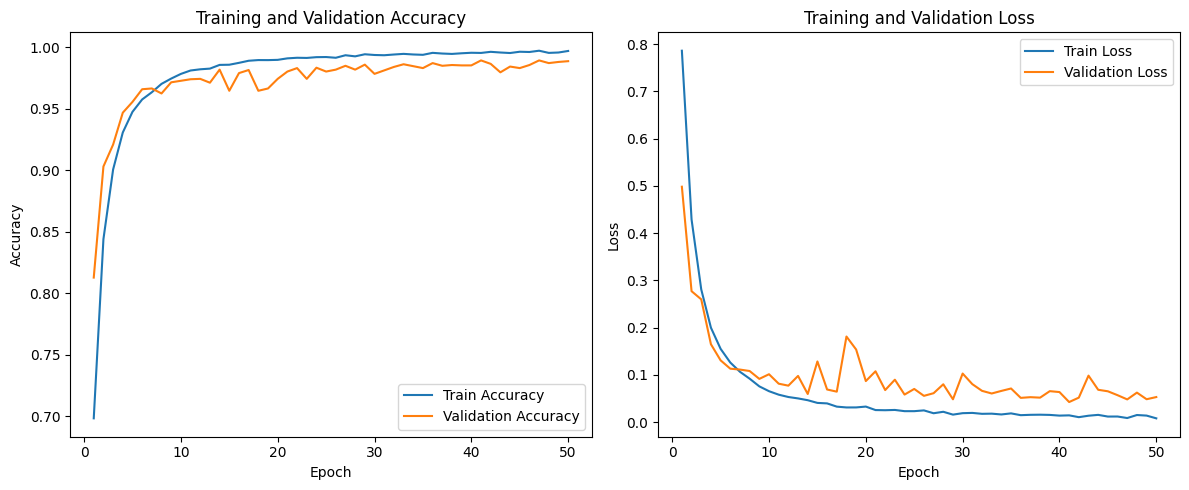

In [13]:
# Step 2: Plot the metrics
plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

class_names = test_set.classes
# Function to compute and plot Confusion Matrix with sorted labels
def compute_confusion_matrix(model, data_loader, dataset_name, device, class_names):
    model.eval()  # Set model to evaluation mode
    true_labels = []
    predictions = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    # Compute confusion matrix with correct label order
    cm = confusion_matrix(true_labels, predictions, labels=np.arange(len(class_names)))
    
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.show()

    # Print classification report
    print(f'Classification Report for {dataset_name}:')
    print(classification_report(true_labels, predictions, target_names=class_names))
    
    print(f"{dataset_name} Metrics: "
          f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, F1-Score: {f1:.4f}")


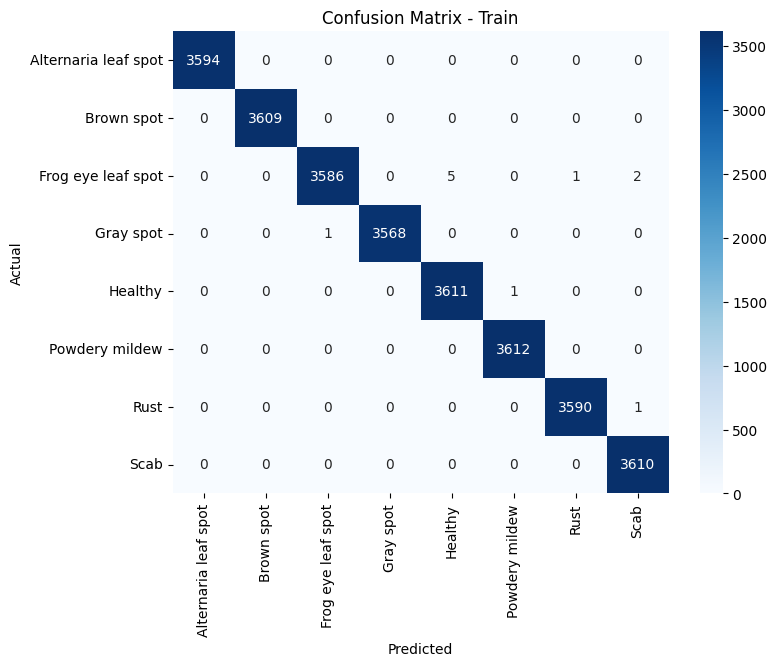

Classification Report for Train:
                      precision    recall  f1-score   support

Alternaria leaf spot       1.00      1.00      1.00      3594
          Brown spot       1.00      1.00      1.00      3609
  Frog eye leaf spot       1.00      1.00      1.00      3594
           Gray spot       1.00      1.00      1.00      3569
             Healthy       1.00      1.00      1.00      3612
      Powdery mildew       1.00      1.00      1.00      3612
                Rust       1.00      1.00      1.00      3591
                Scab       1.00      1.00      1.00      3610

            accuracy                           1.00     28791
           macro avg       1.00      1.00      1.00     28791
        weighted avg       1.00      1.00      1.00     28791

Train Metrics: Accuracy: 0.9996, Precision: 0.9996, Recall: 0.9996, F1-Score: 0.9996


In [15]:
compute_confusion_matrix(model, train_loader, "Train", device, class_names)


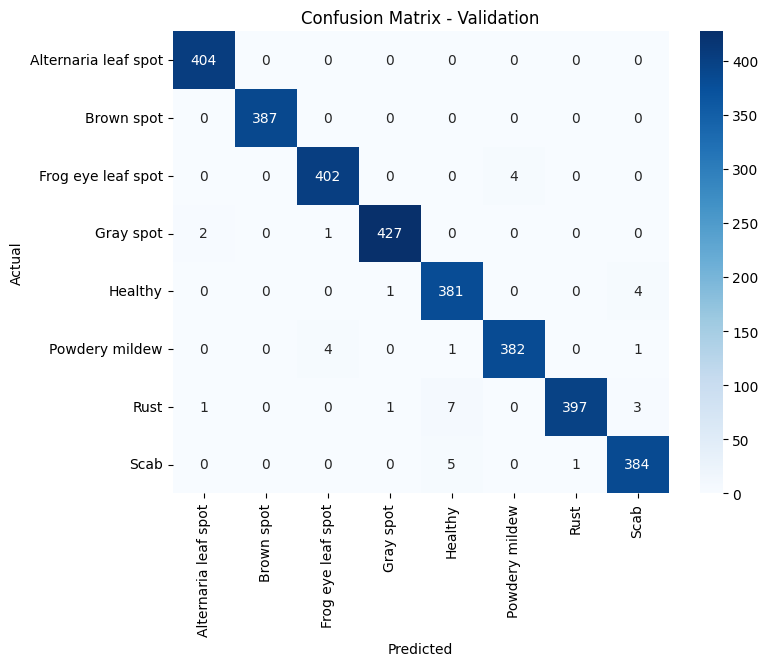

Classification Report for Validation:
                      precision    recall  f1-score   support

Alternaria leaf spot       0.99      1.00      1.00       404
          Brown spot       1.00      1.00      1.00       387
  Frog eye leaf spot       0.99      0.99      0.99       406
           Gray spot       1.00      0.99      0.99       430
             Healthy       0.97      0.99      0.98       386
      Powdery mildew       0.99      0.98      0.99       388
                Rust       1.00      0.97      0.98       409
                Scab       0.98      0.98      0.98       390

            accuracy                           0.99      3200
           macro avg       0.99      0.99      0.99      3200
        weighted avg       0.99      0.99      0.99      3200

Validation Metrics: Accuracy: 0.9888, Precision: 0.9888, Recall: 0.9888, F1-Score: 0.9888


In [16]:
compute_confusion_matrix(model, val_loader, "Validation", device, class_names)

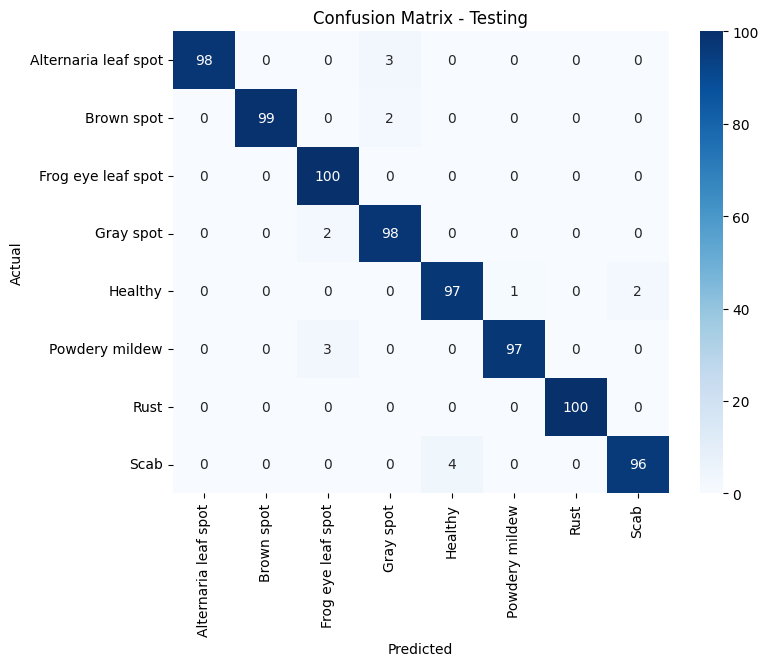

Classification Report for Testing:
                      precision    recall  f1-score   support

Alternaria leaf spot       1.00      0.97      0.98       101
          Brown spot       1.00      0.98      0.99       101
  Frog eye leaf spot       0.95      1.00      0.98       100
           Gray spot       0.95      0.98      0.97       100
             Healthy       0.96      0.97      0.97       100
      Powdery mildew       0.99      0.97      0.98       100
                Rust       1.00      1.00      1.00       100
                Scab       0.98      0.96      0.97       100

            accuracy                           0.98       802
           macro avg       0.98      0.98      0.98       802
        weighted avg       0.98      0.98      0.98       802

Testing Metrics: Accuracy: 0.9788, Precision: 0.9793, Recall: 0.9788, F1-Score: 0.9789


In [17]:
compute_confusion_matrix(model, test_loader, "Testing", device, class_names)

In [18]:
# Save model
torch.save(model.state_dict(), 'pre_trained/MobileNetV3-SKA-CA-dict-rundataset-MSFE-realska-realmsfe.pth')
torch.save(model, 'pre_trained/MobileNetV3-SKA-CA-rundataset-MSFE-realska-realmsfe.pth')

In [19]:
# Save training history

# Combine lists into a dictionary
history = {
    'train_loss': train_losses,
    'train_acc': train_accuracies,
    'val_loss': val_losses,
    'val_acc': val_accuracies
}

# Save to file
torch.save(history, 'training_history/training_history-SKA-CA-rundataset-MSFE-realska-realmsfe.pth')
print("Training history saved successfully!")

Training history saved successfully!


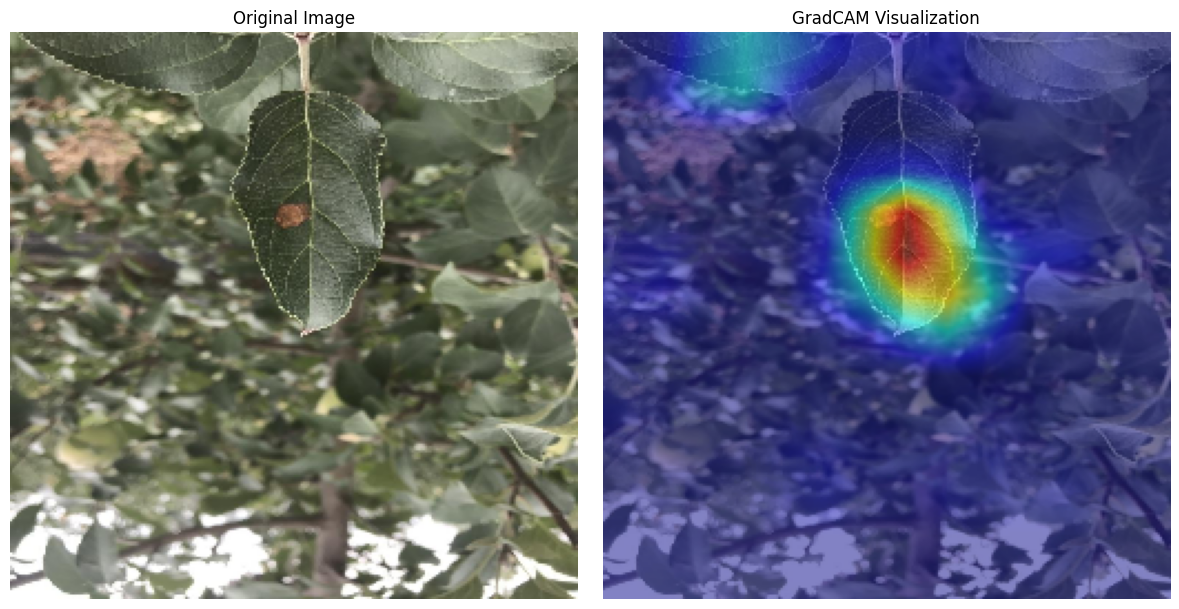

In [31]:
import torch
import cv2
import numpy as np
from PIL import Image
from torchvision import models, transforms
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

# Load the pre-trained MobileNetV3 Large model and set it to evaluation mode.
model.to(device)
model.eval()

# Choose a target layer. For MobileNetV3, a good candidate is the last convolution layer.
target_layer = model.features[-1]

# IMPORTANT: Use 'target_layers' (a list) instead of 'target_layer'
cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

# Preprocess your input image:
image_path = "rundataset/test_set/Alternaria leaf spot/000819.jpg"  # Replace with your image file path.
img_bgr = cv2.imread(image_path, 1)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
pil_img = Image.fromarray(img_rgb)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(pil_img).unsqueeze(0).to(device)

# Optionally, set a target category (None uses the model's top predicted class).
target_category = None  

# Generate the GradCAM++ map.
grayscale_cam = cam(input_tensor=input_tensor, targets=target_category)

# Resize the CAM to match the original image dimensions.
cam_resized = cv2.resize(grayscale_cam[0], (img_rgb.shape[1], img_rgb.shape[0]))

# Overlay the CAM on the original image (normalized between 0 and 1).
visualization = show_cam_on_image(np.float32(img_rgb) / 255.0, cam_resized, use_rgb=True)

# Save or display the visualization.
# cv2.imwrite("cam_mobilenetv3.jpg", cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR))

# Display both the original image and the visualization side by side.
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Show original image.
axs[0].imshow(img_rgb)
axs[0].set_title("Original Image")
axs[0].axis("off")

# Show GradCAM++ visualization.
axs[1].imshow(visualization)
axs[1].set_title("GradCAM Visualization")
axs[1].axis("off")

plt.tight_layout()
plt.show()